In [ ]:
import numpy as np
np.random.seed( 42 )
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation,Dropout,Layer,AveragePooling2D
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import time
from scipy.stats.mstats import gmean

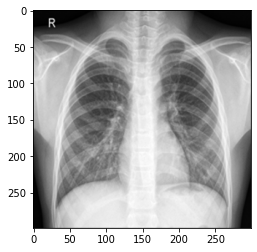

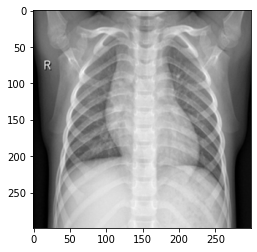

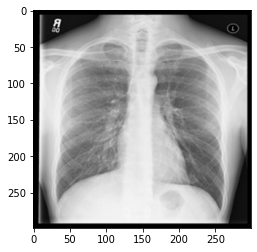

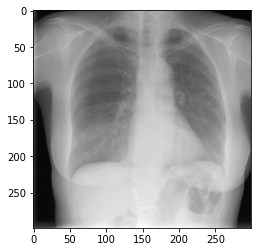

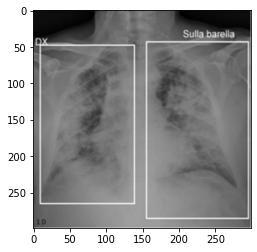

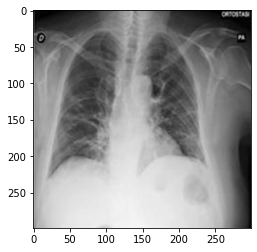

In [2]:
DATA_path  ="../input/covid19-radiography-database/COVID-19_Radiography_Dataset"
CATEGORIES = ["Normal","COVID" ]
for category in CATEGORIES:  # do covid & NORMAL
    path = os.path.join(DATA_path ,category)  # create path to NORMAL & covid
    x=0
    for img in os.listdir(path):  # iterate over each image per NORMAL & covid
        x+=1
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')# graph it
        plt.show()  # display!
        if x==3 :
            break
                  

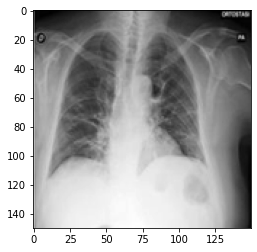

In [3]:
#test size
IMG_SIZE = 150
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [4]:
all_data = []

def create_data():
    for category in CATEGORIES:  # do non_covid & covid

        path = os.path.join(DATA_path,category)  # create path to non_covid & covid
        class_num = CATEGORIES.index(category)  # get the classification  (0 or  1). 0=non_covid 1=covid

        for img in tqdm(os.listdir(path)):  # iterate over each image per non_covid & covid
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                all_data.append([new_array, class_num])  # add this to our data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
           

create_data()

print(len(all_data))

100%|██████████| 3616/3616 [00:36<00:00, 100.23it/s]

13808


In [5]:
covid=[]
normal=[]
for data in all_data:
  if (data[:][1])==1:
    covid.append(data)
  else:
    normal.append(data)
print(len(covid))
print(len(normal))

3616
10192


In [6]:
#Handling imbalanced dataset 
normal =normal[:3616]
print(len(normal))
print(len(covid))
all_data=covid+normal
print(len(all_data))

3616
3616
7232


In [7]:
import random
random.shuffle(all_data)
for sample in all_data[:10]:
    print(sample[1])

1
1
0
0
0
0
1
0
0
0


In [8]:
x = []
y = []

for features,label in all_data:
    x.append(features)
    y.append(label)
#print(x_train[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))
print(x[0])

x = np.array(x).reshape(-1, IMG_SIZE,IMG_SIZE,1)
y = np.array(y)
print("***********\n",x[0])
print(x.shape)



[[  2   2   2 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [114 124 136 ...  35  39  42]
 [112 120 132 ...  33  36  40]
 [116 124 134 ...  31  36  40]]
***********
 [[[  2]
  [  2]
  [  2]
  ...
  [  0]
  [  0]
  [  0]]

 [[  1]
  [  1]
  [  1]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 ...

 [[114]
  [124]
  [136]
  ...
  [ 35]
  [ 39]
  [ 42]]

 [[112]
  [120]
  [132]
  ...
  [ 33]
  [ 36]
  [ 40]]

 [[116]
  [124]
  [134]
  ...
  [ 31]
  [ 36]
  [ 40]]]
(7232, 150, 150, 1)


In [9]:
# np.seterr(divide = 'ignore')

In [10]:
# normalize images
def prep_normalize(x):
    # convert from integers to floats
	x_norm = x.astype('float32')
	# normalize to range 0-1
	x_norm = x_norm / 255.0
	# return normalized images
	return x_norm
# center images
def Arithmetic_mean(x):
	# convert from integers to floats
	x_cent = x.astype('float32')
	# calculate statistics
	m = x_cent.mean()
	# center datasets
	x_cent = x_cent - m
	# return normalized images
	return x_cent
def geometric_mean(x):
	# convert from integers to floats
	x_gmean = x.astype('float32')
	# calculate statistics
	m = gmean(x_gmean)
	# center datasets
	x_gmean = x_gmean - m
	# return normalized images
	return x_gmean
# standardize images
def prep_standardize(x):
	# convert from integers to floats
	x_stan = x.astype('float32')
	# calculate statistics
	m = x_stan.mean()
	s = x_stan.std()
	# center datasets
	x_stan = (x_stan - m) / s
	# return normalized images
	return x_stan
def RobustScaling(x):
    # convert from integers to floats
    x_Robust = x.astype('float32')
    median=np.percentile(x_Robust, 50, axis=0)
    # First quartile (Q1)
    Q1 = np.percentile(x_Robust, 25,axis=0)
    # Third quartile (Q3)
    Q3 = np.percentile(x_Robust, 75,axis=0)
    #RobustScaling
    x_Robust =(x_Robust-median)/(Q3 - Q1)
    return x_Robust
def minmaxScaler(x,min,max):
    X_std = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [11]:
# x=prep_normalize(x)
#x=Arithmetic_mean(x)
#x=geometric_mean(x)
#x=prep_standardize(x)
x =RobustScaling(x)
#x =minmaxScaler(x,0,1)
# print(x[0])

In [12]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
# print(len(X_train))
# print(len(X_test))

In [13]:
# def build_model(hp):
#     model = keras.Sequential()
#     model.add(Conv2D(filters=hp.Int("input_units",min_value=32,max_value=256,step=32),
#                             kernel_size=hp.Choice('conv_1_kernel',values = [3,5,7]),
#                             input_shape =(IMG_SIZE,IMG_SIZE,1),
#                             padding='same', data_format='channels_last'))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(3,3),padding='same', data_format='channels_last'))
    
#     for i in range(hp.Int("n_layers_cnn",1,4)):
        
#         model.add(Conv2D(filters=hp.Int(f"conv_{i}_units",min_value=32,max_value=256,step=32),
#                          kernel_size=hp.Choice(f'conv_{i}_kernel',values = [3,5,7]),
#                          padding='same', data_format='channels_last'))
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(3,3),padding='same', data_format='channels_last'))


#     model.add(Flatten())
    
#     for i in range(hp.Int('num_layers_nn',1,4)):
#         model.add(Dense(units=hp.Int('units_' + str(i),
#                                      min_value=32,
#                                      max_value=700,
#                                      step=32),
#                               activation='relu'))

#     model.add(Dense(2, activation='softmax'))

#     model.compile(optimizer= "adam",
#                   loss= 'sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model


In [14]:
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=20,
#     executions_per_trial=15,
#     directory='my_dir',
#     project_name='CNNRS')

# tuner.search_space_summary()


In [15]:
# tuner.search(X_train, y_train,
#              epochs=15,
#              batch_size=64,
#              validation_data=(X_test, y_test)
#             )

In [16]:
# tuner.results_summary(num_trials=1)

In [17]:
def build_classifier():
    model = keras.Sequential()
    model.add(Conv2D(filters=32,kernel_size=5,input_shape =(IMG_SIZE,IMG_SIZE,1),
                   padding='same', data_format='channels_last'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4,4),padding='same', data_format='channels_last'))
    
        
    model.add(Conv2D(filters=192,kernel_size=3,
                   padding='same', data_format='channels_last'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4,4),padding='same', data_format='channels_last'))

    model.add(Flatten())
    model.add(Dense(units=96,activation='relu'))
    model.add(Dense(units=32,activation='relu'))

    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer= "adam",
                  loss= 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model=tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_classifier,epochs=23,batch_size=64)

In [18]:
k_fold =10
tic=time.time()
k_score=cross_val_score(model,x,y,cv=k_fold)
toc=time.time()
print(k_score)
print("Time of execution",toc-tic)

Epoch 1/23
102/102 [==============================] - 6s 18ms/step - loss: 0.5304 - accuracy: 0.7026
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.2335 - accuracy: 0.9101
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1377 - accuracy: 0.9560
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0935 - accuracy: 0.9693
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0685 - accuracy: 0.9761
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0533 - accuracy: 0.9790
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0292 - accuracy: 0.9900
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0177 - accuracy: 0.9948
Epoch 9/23
102/102 [==============================] - 2s 18ms/step - loss: 0.0152 - accuracy: 0.9951
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0316 - accura

In [19]:
#with scale
print(k_score*100)
print("K_fold Average of Accuracy = ",k_score.mean()*100,"%")
print("Time of execution",toc-tic)

[97.23756909 97.09944725 96.8188107  96.26556039 97.23374844 98.06362391
 97.09543586 97.37206101 97.51037359 96.40387297]
K_fold Average of Accuracy =  97.1100503206253 %
Time of execution 425.44621443748474


In [20]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model, x,y, cv=10)

Epoch 1/23
102/102 [==============================] - 2s 18ms/step - loss: 0.5952 - accuracy: 0.7005
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.2488 - accuracy: 0.8991
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1761 - accuracy: 0.9394
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1057 - accuracy: 0.9660
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0828 - accuracy: 0.9722
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0530 - accuracy: 0.9814
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0393 - accuracy: 0.9865
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0263 - accuracy: 0.9920
Epoch 9/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0345 - accuracy: 0.9884
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0179 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 17ms/step - loss: 0.5515 - accuracy: 0.7028
Epoch 2/23
102/102 [==============================] - 2s 18ms/step - loss: 0.2219 - accuracy: 0.9152
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1434 - accuracy: 0.9490
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1079 - accuracy: 0.9582
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0698 - accuracy: 0.9733
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0399 - accuracy: 0.9861
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0286 - accuracy: 0.9902
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0165 - accuracy: 0.9941
Epoch 9/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0169 - accuracy: 0.9940
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0146 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 17ms/step - loss: 0.4787 - accuracy: 0.7659
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1916 - accuracy: 0.9325
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1305 - accuracy: 0.9483
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0798 - accuracy: 0.9714
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0597 - accuracy: 0.9787
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0366 - accuracy: 0.9870
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0284 - accuracy: 0.9901
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0356 - accuracy: 0.9873
Epoch 9/23
102/102 [==============================] - 2s 19ms/step - loss: 0.0222 - accuracy: 0.9929
Epoch 10/23
102/102 [==============================] - 2s 19ms/step - loss: 0.0075 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 17ms/step - loss: 0.4608 - accuracy: 0.7552
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.2035 - accuracy: 0.9228
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1403 - accuracy: 0.9473
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0888 - accuracy: 0.9698
Epoch 5/23
102/102 [==============================] - 2s 18ms/step - loss: 0.0625 - accuracy: 0.9761
Epoch 6/23
102/102 [==============================] - 2s 18ms/step - loss: 0.0453 - accuracy: 0.9860
Epoch 7/23
102/102 [==============================] - 2s 20ms/step - loss: 0.0367 - accuracy: 0.9877
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0198 - accuracy: 0.9928
Epoch 9/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0218 - accuracy: 0.9934
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0084 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 18ms/step - loss: 0.4774 - accuracy: 0.7632
Epoch 2/23
102/102 [==============================] - 2s 20ms/step - loss: 0.2229 - accuracy: 0.9125
Epoch 3/23
102/102 [==============================] - 2s 18ms/step - loss: 0.1296 - accuracy: 0.9522
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0914 - accuracy: 0.9645
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0732 - accuracy: 0.9734
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0311 - accuracy: 0.9896
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0398 - accuracy: 0.9871
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0230 - accuracy: 0.9918
Epoch 9/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0095 - accuracy: 0.9978
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0178 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 17ms/step - loss: 0.5664 - accuracy: 0.7256
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.2213 - accuracy: 0.9165
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1580 - accuracy: 0.9436
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1149 - accuracy: 0.9591
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0742 - accuracy: 0.9741
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0780 - accuracy: 0.9721
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0305 - accuracy: 0.9929
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0477 - accuracy: 0.9825
Epoch 9/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0265 - accuracy: 0.9912
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0114 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 17ms/step - loss: 0.5762 - accuracy: 0.6939
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.2252 - accuracy: 0.9159
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1432 - accuracy: 0.9520
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1103 - accuracy: 0.9580
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0787 - accuracy: 0.9715
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0501 - accuracy: 0.9863
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0333 - accuracy: 0.9887
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0240 - accuracy: 0.9912
Epoch 9/23
102/102 [==============================] - 2s 18ms/step - loss: 0.0168 - accuracy: 0.9961
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0168 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 17ms/step - loss: 0.6118 - accuracy: 0.6918
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.2274 - accuracy: 0.9136
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1605 - accuracy: 0.9401
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1090 - accuracy: 0.9599
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0686 - accuracy: 0.9786
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0398 - accuracy: 0.9881
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0287 - accuracy: 0.9914
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0274 - accuracy: 0.9900
Epoch 9/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0335 - accuracy: 0.9876
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0134 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 17ms/step - loss: 0.5864 - accuracy: 0.6415
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.2264 - accuracy: 0.9097
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1871 - accuracy: 0.9244
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1270 - accuracy: 0.9516
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0796 - accuracy: 0.9719
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0579 - accuracy: 0.9799
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0401 - accuracy: 0.9864
Epoch 8/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0384 - accuracy: 0.9861
Epoch 9/23
102/102 [==============================] - 2s 18ms/step - loss: 0.0312 - accuracy: 0.9899
Epoch 10/23
102/102 [==============================] - 2s 19ms/step - loss: 0.0182 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/23
102/102 [==============================] - 2s 17ms/step - loss: 0.5254 - accuracy: 0.7307
Epoch 2/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1928 - accuracy: 0.9278
Epoch 3/23
102/102 [==============================] - 2s 17ms/step - loss: 0.1369 - accuracy: 0.9505
Epoch 4/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0891 - accuracy: 0.9684
Epoch 5/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0760 - accuracy: 0.9750
Epoch 6/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0411 - accuracy: 0.9881
Epoch 7/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0257 - accuracy: 0.9924
Epoch 8/23
102/102 [==============================] - 2s 18ms/step - loss: 0.0257 - accuracy: 0.9895
Epoch 9/23
102/102 [==============================] - 2s 18ms/step - loss: 0.0117 - accuracy: 0.9970
Epoch 10/23
102/102 [==============================] - 2s 17ms/step - loss: 0.0091 - accura

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<AxesSubplot:>

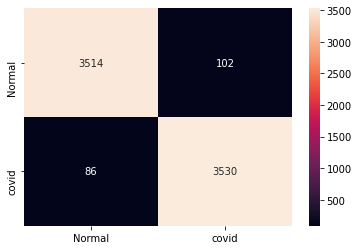

In [21]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(y, y_pred)
sn.heatmap(confusion_matrix, annot=True, fmt=".4g",xticklabels=['Normal','covid'],yticklabels=['Normal','covid']) # font size

In [22]:
tic=time.time()
history = model.fit(x, y, validation_split=0.15)
toc=time.time()
print("Time of execution",toc-tic)

Epoch 1/23
97/97 [==============================] - 3s 25ms/step - loss: 0.4986 - accuracy: 0.7213 - val_loss: 0.2207 - val_accuracy: 0.9161
Epoch 2/23
97/97 [==============================] - 2s 19ms/step - loss: 0.1997 - accuracy: 0.9249 - val_loss: 0.1816 - val_accuracy: 0.9290
Epoch 3/23
97/97 [==============================] - 2s 18ms/step - loss: 0.1261 - accuracy: 0.9559 - val_loss: 0.3286 - val_accuracy: 0.8820
Epoch 4/23
97/97 [==============================] - 2s 18ms/step - loss: 0.1279 - accuracy: 0.9488 - val_loss: 0.1807 - val_accuracy: 0.9410
Epoch 5/23
97/97 [==============================] - 2s 18ms/step - loss: 0.0698 - accuracy: 0.9723 - val_loss: 0.1390 - val_accuracy: 0.9502
Epoch 6/23
97/97 [==============================] - 2s 18ms/step - loss: 0.0459 - accuracy: 0.9850 - val_loss: 0.2645 - val_accuracy: 0.9244
Epoch 7/23
97/97 [==============================] - 2s 18ms/step - loss: 0.0457 - accuracy: 0.9834 - val_loss: 0.1930 - val_accuracy: 0.9493
Epoch 8/23
97

In [23]:
# model.model.evaluate(X_test,y_test)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


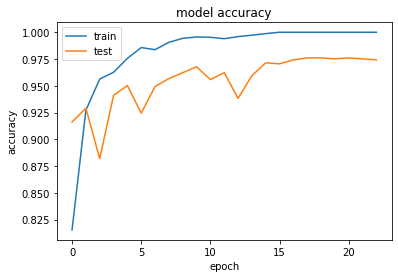

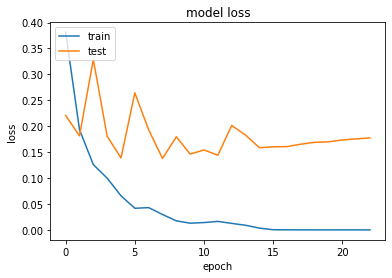

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
keras_file="cnn_covid19_model.h5"
model.model.save(keras_file)
h5model=tf.keras.models.load_model(keras_file)
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(h5model)
tflit_model = converter.convert()

# Save the model.
with open('cnn_covid19_RobustScaling.tflite', 'wb') as f:
    f.write(tflit_model)